In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pickle

### Description of the sequence of actions <a class="anchor" id="contents"></a>
- [Introduction](#Introduction)
- [Dataset description](#Dataset-description)
- [Task of the hackathon](#Task-of-the-hackathon)
- [Inspect available logs and interpretations](#Inspect-available-logs-and-interpretations)
- [Preparing data for training](#Preparing-data-for-training)
- [Making predction on test dataset](#Making-predction-on-test-dataset)

### Introduction
[back to table of contents](#contents)

In the Jupyter notebook presented, we are introducing an approach to determine lithology from labeled core and well log data for one oil and gas field. The lithology labels from core data are used to train a supervised machine learning algorithm to predict lithology from well log response. This algorithm can be extended to any other reservoir to improve rock type prediction.

Coring is an expensive operation, leading to only a small number wells in specific intervals core is retrieved. Opposite to coring, well logging is relatively inexpensive and is a standard operation. The relationship between lithology and well log data is often overwhelming, complex, and nonlinear. Recently, many studies have shown that machine learning algorithms could improve lithology prediction. The main benefits from improved lithology prediction accuracy would be cost and time efficiency which is especially important for decision-making process in reservoir evaluation and management on early stages of field development.

As a baseline solution for the hackathon, we are proposing a k-nearest neighbors classification machine learning algorithm. The aim of supervised learning is to label a small portion of a dataset and allow the algorithm to automate the rest. Such data-driven analysis may optimize well logging, coring, and core analysis program.

Available to participants is a dataset (`Train-dataset.csv`) contains well log curves from 11 wells across one field.

### Dataset description
[back to table of contents](#contents)
#### Gamma ray log (`GR`)
Gamma ray log measures naturally occurring radioactivity of a formation. GR is mainly used for determination of the shaliness of a formation. Values of gamma ray log will be low in clay-free rocks such as sandstones (composed of non-radioactive quartz), limestones, dolostones, anhydrites, most salts and coals, but, on the contrary, high in shales because of high concentrations of radioactive material. However, clean sandstone (i.e., with low shale content) might also produce a high gamma ray response if the sandstone contains potassium feldspars, micas, organic materials (with absorbed uranium), uranium-rich waters or radioactive minerals. Limestones and dolostone also can contain radioactive organic materials or uranium-rich waters. Some coals could be radioactive due to presence of radioactive elements such uranium, thorium, potassium-40, radium and polonium.

#### Compensated neutron / Thermal Neutron Porosity log (`CN`)
Neutron log is counting the amount of hydrogen atoms in a formation. The tool operates by bombarding the formation with high energy neutrons. These neutrons collide with hydrogen atoms and undergo scattering in the formation, losing energy and producing high energy gamma rays after absorbtion. These high energy gamma rays relate to formation porosity. CN is given in porosity units after being calibrated to become a direct indicator of porosity magnitude with some approximation. There are anomalous absorbers of neutrons such as chlorium that can significantly change total flow of neutrons and produced gamma rays. Hydrogen is concentrated in fluids (oil and water) in pores and hence neutron log is an indicator of porosity, but hydrogen is also contained in chemical structure of minerals, which is significant in shales. Some pores can contain gas, which presented with low concentration of hydrogen, then will not reflects porosity.

#### Density (`DEN`)
Density log is related to the bulk density of formation. The tool principle is based on a radioactive source and counter. As the tool is run against the borehole wall it emits radioactive particles that interact with electrons in formation via Compton scattering, resulting gamma ray is counted and analyzed to determine the bulk density of a rock. The bulk density is the overall density of the matrix and the fluids (water, oil, gas) within the pores. Hence the traditional use of density log is determination of porosity. In formation with low porosity, measured density values will be closer to the mineralogical (matrix) density, and with increase of porosity density values will get lower. Density porosity is often considered to be better than CN and Sonic Log in terrigenous rocks because it is less affected by shaliness since quartz, feldspar and dry clay mineral have comparable densities. Measured density curve is used for lithology differentiation, especially in combination with CN.

#### Resistivity (`RT`)
Resistivity log is an indicator of capability of the formation to prevent current flow through it. Hydrocarbons and non-porous rocks do not conduct electric current, but when rock is porous, and pores are interconnected and saturated with formation water, current can flow. Therefore, a difference in resistivity of non-porous rocks, hydrocarbon saturated formation and saline water saturated formation exists and it is essential in identification of hydrocarbon bearing zones. There are other factors also affecting resistivity values. Clay and other minerals, such as pyrite, are conductive and reduce the resistivity values.

#### Metadata
Dataset contains metadata columns:
- `WELL` - name of a well
- `X` - coordinate
- `Y` - coordinate
- `MD` - measured depth of a well log response
- `DEPOSITIONAL_ENVIRONMENT` - describes the conditions in which the sediments is deposited. Different depositional environments influence on trend of some well log curves and presence of certain lithology classes
- `LITH_NAME` is a lithology class label
- `LITH_CODE` is a lithology code

The following materias used for prepare well-log curves description:
1. Darling, T.. (2005). Well Logging and Formation Evaluation. 10.1016/B978-0-7506-7883-4.X5000-1. 
2. Serra, Oberto. (1984). Fundamentals of well-log interpretation. Vol. 1: The acquisition of logging data.
3. http://homepages.see.leeds.ac.uk/~earpwjg/PG_EN/CD%20Contents/GGL-66565%20Petrophysics%20English/Contents.PDF

### Task of the hackathon
[back to table of contents](#contents)

The validation of your prediction will be performed on a validation dataset (`Validation-dataset.csv`) with a similar lithology class distribution as the training set. The metric by which the solution will be evaluated is weighted F1 score. We encourage participants to try additional features that could increase the F1 score of the model. For example, look for the spatial correlation of the features, explore the relation between discrete variables or try to find some lateral trend in the data.

Your task as a participant is to make the best lithology prediction you can and submit your prediction in a CSV file that contains only one column with predicted class of lithology (`LITH_CODE`). CSV file with prediction should not contain the header.

### Inspect available logs and interpretations
[back to table of contents](#contents)

In [2]:
df = pd.read_csv('data/Train-dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45749 entries, 0 to 45748
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WELL                      45749 non-null  object 
 1   X                         45749 non-null  float64
 2   Y                         45749 non-null  float64
 3   MD                        45749 non-null  float64
 4   GR                        45749 non-null  float64
 5   RT                        45749 non-null  float64
 6   CN                        45749 non-null  float64
 7   DEN                       45749 non-null  float64
 8   DEPOSITIONAL_ENVIRONMENT  45749 non-null  object 
 9   LITH_NAME                 45749 non-null  object 
 10  LITH_CODE                 45749 non-null  int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 3.8+ MB


In [3]:
df.sample(8)

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_NAME,LITH_CODE
33447,Well-10,3.0000,0.0000,1045.500,87.54360,5.27293,0.32639,2.27030,Continental,Sandy marl,1300
24564,Well-7,1.3109,2.0912,1178.183,61.35197,4.91320,0.34437,2.09194,Transitional,Sandstone,600
43566,Well-10,3.0000,0.0000,2057.400,94.63620,1.72228,0.32429,2.41590,Marine,Clay marl,400
40465,Well-10,3.0000,0.0000,1747.300,91.22070,2.49021,0.30927,2.38660,Marine,Clay marl,400
39153,Well-10,3.0000,0.0000,1616.100,87.38710,4.76169,0.25581,2.34390,Transitional,Sandstone,600
8442,Well-11,0.7564,1.9833,735.100,95.25370,4.93520,0.37157,2.18930,Continental,Clay,100
17389,Well-11,0.7564,1.9833,1629.800,92.75520,3.59650,0.27575,2.36010,Transitional,Clay marl,400
34223,Well-10,3.0000,0.0000,1123.100,76.70900,5.57924,0.32499,2.23470,Continental,Clay sandstone,500


There are 11 wells in the training dataset:

In [4]:
wells = df['WELL'].unique()
print(wells)

['Well-1' 'Well-9' 'Well-4' 'Well-2' 'Well-3' 'Well-8' 'Well-5' 'Well-6'
 'Well-11' 'Well-7' 'Well-10']


Look at log curves for a couple of wells (change wells number for different well)

(1810.0, 697.6)

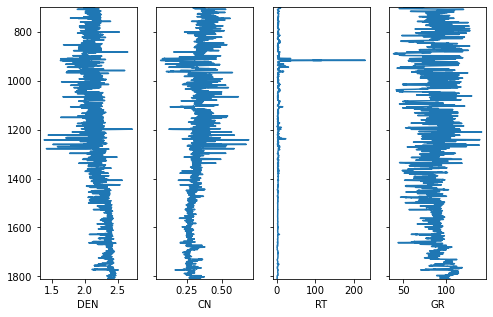

In [5]:
well_data = df[df['WELL'] == wells[8]]
fig, axs = plt.subplots(1, len(well_data.columns)-7, figsize=(8, 5), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['WELL',
                                                     'MD',
                                                     'X',
                                                     'Y',
                                                     'DEPOSITIONAL_ENVIRONMENT',
                                                     'LITH_NAME',
                                                     'LITH_CODE'])):
    axs[ic].plot(well_data[col], well_data['MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['MD'].values[-1], well_data['MD'].values[0])

See how each lithology class is presented in dataset:

In [6]:
df['LITH_NAME'].value_counts()

Sandstone          11572
Clay marl           8054
Clay                7716
Clay sandstone      6496
Sandy marl          5677
Coal                2547
Marl                1236
Marly sandstone      889
Tight                693
Coal clay            443
Siltstone clay       340
Marl clay             83
Siltstone/Loess        3
Name: LITH_NAME, dtype: int64

Or plot lithology distribution to get the clear picture:

In [7]:
lithology_color = {100: '#997950',
                    200: '#cccccc',
                    300: '#ffff00',
                    400: '#ffccff',
                    500: '#006600',
                    600: '#666600',
                    700: '#F8DE7E',
                    800: '#999DA0',
                    900: '#9933ff',
                    1000: '#ff6600',
                    1100: '#000000',
                    1200: '#98FB98',
                    1300: '#ff9999',
                    1400: '#CEB180',
                    1500: '#3BB143'
                    }

lithology_key = {100: 'Clay',
                 200: 'Siltstone/Loess',
                 300: 'Marl',
                 400: 'Clay marl',
                 500: 'Clay sandstone',
                 600: 'Sandstone',
                 700: 'Limestone',
                 800: 'Tight',
                 900: 'Dolomite',
                 1000: 'Coal',
                 1100: 'Coal clay',
                 1200: 'Marly sandstone',
                 1300: 'Sandy marl',
                 1400: 'Marl clay',
                 1500: 'Siltstone clay'
                  }

In [8]:
def autolabel(ax, bars, labels):
    """Attach a text label above each bar."""
    for bar, label in zip(bars, labels):
        height = bar.get_height()
        ax.annotate('{}'.format(label),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

<ipython-input-9-3d60b39b06de>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation=45)


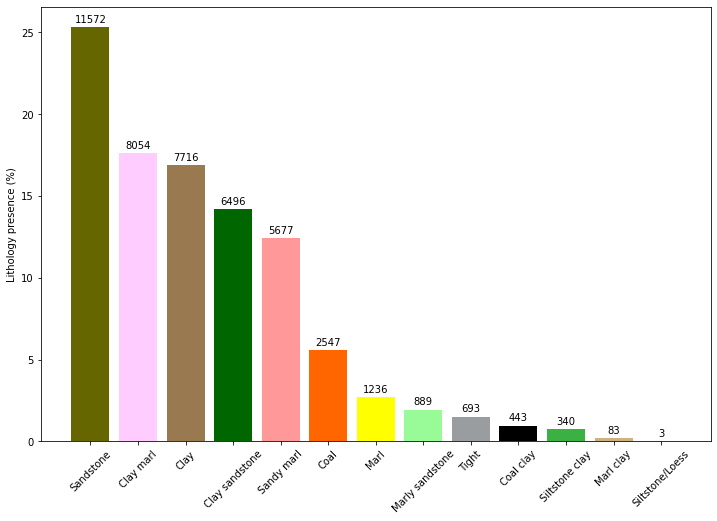

In [9]:
counts = df['LITH_CODE'].value_counts()
names = []
percentage = []
numbers = []
colors = []
N = df['LITH_CODE'].shape[0]
for item in counts.iteritems():
    names.append(lithology_key[item[0]])
    percentage.append(float(item[1]) / N*100)
    numbers.append(int(item[1]))
    colors.append(lithology_color[item[0]])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bar = ax.bar(x=np.arange(len(names)), height=percentage, color=colors)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (%)')

autolabel(ax, bar, numbers)

Convert categorical varable DEPOSITIONAL_ENVIRONMENT to int variable and append them to the feature df

In [10]:
MAPPING = {
    'Continental': 1,
    'Transitional': 2,
    'Marine': 3,
}

df['D_Env']=df['DEPOSITIONAL_ENVIRONMENT'].apply(lambda x: MAPPING[x])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45749 entries, 0 to 45748
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WELL                      45749 non-null  object 
 1   X                         45749 non-null  float64
 2   Y                         45749 non-null  float64
 3   MD                        45749 non-null  float64
 4   GR                        45749 non-null  float64
 5   RT                        45749 non-null  float64
 6   CN                        45749 non-null  float64
 7   DEN                       45749 non-null  float64
 8   DEPOSITIONAL_ENVIRONMENT  45749 non-null  object 
 9   LITH_NAME                 45749 non-null  object 
 10  LITH_CODE                 45749 non-null  int64  
 11  D_Env                     45749 non-null  int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 4.2+ MB


### Preparing data for training
[back to table of contents](#contents)

Selecting features for the model, scaling and train and test split

In [11]:
Feature = df[['MD','GR', 'RT', 'DEN', 'CN','D_Env']]

In [12]:
X = Feature
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X[0:3]

array([[ 0.80679955, -0.05873506, -0.0297766 ,  0.9314631 , -1.24494517,
         1.63516556],
       [ 0.80705772, -0.04447168, -0.0301925 ,  0.98382475, -1.29716711,
         1.63516556],
       [ 0.8073159 ,  0.01138796, -0.03080964,  0.98382475, -1.32327808,
         1.63516556]])

In [13]:
y = df['LITH_CODE']
y[0:3]

0    1200
1    1200
2    1200
Name: LITH_CODE, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (36599, 6) (36599,)
Test set: (9150, 6) (9150,)


In [15]:
def show_conf_matrix(y_predict, y_test, classes):
    
    # Calculate confusion matrix
    conf = confusion_matrix(y_predict, y_test)

    plt.figure(figsize=(10,8))
    sns.set(font_scale=1) # for label size
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, cmap="YlGnBu", xticklabels=classes, yticklabels=classes) # font size

    plt.show()

In [16]:
target_lithologys = []
labels = np.sort(y_test.unique())

for l_code in labels:
    lithology = lithology_key[l_code]
    target_lithologys.append(lithology)

print(labels)
print(target_lithologys)

[ 100  200  300  400  500  600  800 1000 1100 1200 1300 1400 1500]
['Clay', 'Siltstone/Loess', 'Marl', 'Clay marl', 'Clay sandstone', 'Sandstone', 'Tight', 'Coal', 'Coal clay', 'Marly sandstone', 'Sandy marl', 'Marl clay', 'Siltstone clay']


In [17]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):

    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.f1_score(y_test, yhat, average='weighted')

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.82334816, 0.81376095, 0.83393386, 0.82721039, 0.82745056,
       0.82359348, 0.82414665, 0.81986594, 0.81875318])

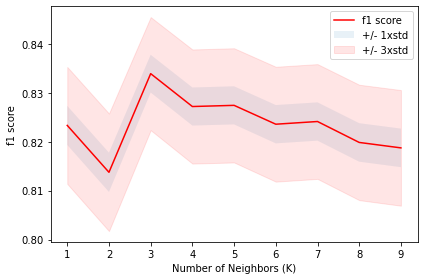

The best accuracy was with 0.8339338571052797 with k= 3


In [18]:
plt.plot(range(1,Ks), mean_acc, 'r')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10, color='r')
plt.legend(('f1 score', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('f1 score')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

Train set accuracy:  0.91
Test set accuracy:  0.83


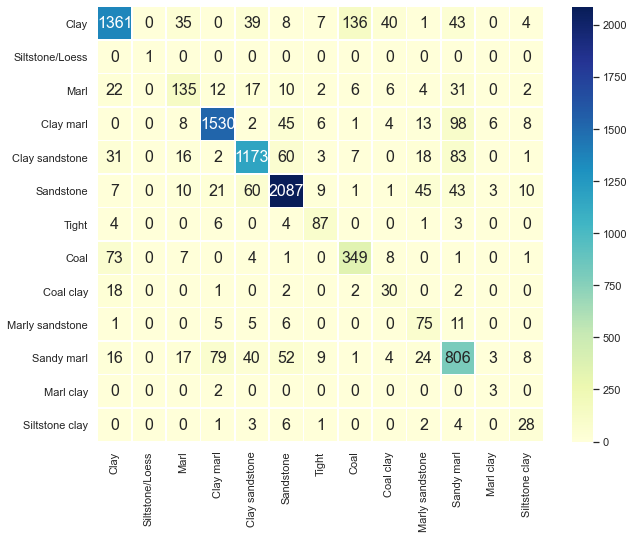

                 precision    recall  f1-score   support

           Clay       0.81      0.89      0.85      1533
Siltstone/Loess       1.00      1.00      1.00         1
           Marl       0.55      0.59      0.57       228
      Clay marl       0.89      0.92      0.91      1659
 Clay sandstone       0.84      0.87      0.86      1343
      Sandstone       0.91      0.91      0.91      2281
          Tight       0.83      0.70      0.76       124
           Coal       0.79      0.69      0.74       503
      Coal clay       0.55      0.32      0.41        93
Marly sandstone       0.73      0.41      0.52       183
     Sandy marl       0.76      0.72      0.74      1125
      Marl clay       0.60      0.20      0.30        15
 Siltstone clay       0.62      0.45      0.52        62

       accuracy                           0.84      9150
      macro avg       0.76      0.67      0.70      9150
   weighted avg       0.83      0.84      0.83      9150



In [19]:
model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

y_predict = model.predict(X_test)

print("Train set accuracy: ", round(metrics.f1_score(y_train, model.predict(X_train), average='weighted'), 2))
print("Test set accuracy: ", round(metrics.f1_score(y_test, y_predict, average='weighted'), 2))

show_conf_matrix(y_predict, y_test, target_lithologys)

print(classification_report(y_test, y_predict, labels=labels, target_names=target_lithologys, zero_division=0))

### Making predction on test dataset
[back to table of contents](#contents)

In [20]:
df_test = pd.read_csv('data/Validation-dataset.csv')
df_test['D_Env'] = df_test['DEPOSITIONAL_ENVIRONMENT'].apply(lambda x: MAPPING[x])
display(df_test.info())
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28997 entries, 0 to 28996
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WELL                      28997 non-null  object 
 1   X                         28997 non-null  float64
 2   Y                         28997 non-null  float64
 3   MD                        28997 non-null  float64
 4   GR                        28997 non-null  float64
 5   RT                        28997 non-null  float64
 6   CN                        28997 non-null  float64
 7   DEN                       28997 non-null  float64
 8   DEPOSITIONAL_ENVIRONMENT  28997 non-null  object 
 9   D_Env                     28997 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 2.2+ MB


None

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,D_Env
0,Well-X,2.9956,0.0061,897.065,92.7094,4.51768,0.36366,2.2106,Continental,1
1,Well-X,2.9956,0.0061,897.165,93.9007,4.30683,0.36951,2.2036,Continental,1
2,Well-X,2.9956,0.0061,897.265,94.8446,3.98902,0.37914,2.1969,Continental,1
3,Well-X,2.9956,0.0061,897.365,95.6321,3.67028,0.39020,2.1923,Continental,1
4,Well-X,2.9956,0.0061,897.465,96.4700,3.63431,0.40098,2.1926,Continental,1


In [21]:
X_pred = scaler.transform(df_test[['MD','GR', 'RT', 'DEN', 'CN', 'D_Env']])
pred = model.predict(X_pred)

pred[:5]

# example of how to save a prediction
#np.savetxt('prediction.csv', pred, delimiter=',', encoding='utf-8') 

array([100, 100, 100, 100, 100])